In [27]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from IPython.display import display
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as path_effects

pio.templates.default = "seaborn"
pd.options.plotting.backend = "plotly"
plt.rcParams.update({
    'font.size': 16,
    'font.family': 'DejaVu Sans',
})

%matplotlib inline
%run global.ipynb

In [28]:
%store -r estimates_df

In [29]:
# The specific date to split the data

split_date = pd.to_datetime('2020-03-16')
# split date minus 3 months
earliest_date = split_date - pd.DateOffset(months=12)
to_date = split_date + pd.DateOffset(months=12)
# days between the earliest date and the split date
days_in_before_period = (split_date - earliest_date).days
ratio_minimum_data = 0.95

fixed_outlier_steps_amount = 50000

In [30]:
# Assuming you have the necessary variables like `earliest_date`, `split_date`, and `ratio_minimum_data`
df = estimates_df.copy()

# Ensure all datetime columns are consistent (timezone-naive)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df['created'] = pd.to_datetime(df['created']).dt.tz_localize(None)

# Pre-filter the DataFrame
df_filtered = df[(df['date'] >= earliest_date)]

def process_user_data(user_data):
    user_id = user_data['userId'].iloc[0]
    created_date = user_data['created'].iloc[0]
    # created_date = to_date
    stepsEstimate = user_data['stepsEstimate'].iloc[0]
    gender = user_data['gender'].iloc[0]
    age_range = user_data['ageRange'].iloc[0]
    
    user_data_before = user_data[user_data['date'] < split_date]
    user_data_after = user_data[(user_data['date'] >= split_date) & (user_data['date'] < created_date)]
    
    days_in_after_period = (created_date - split_date).days
    
    steps_before = user_data_before['steps'].mean()
    steps_after = user_data_after['steps'].mean()
    
    if len(user_data_before) < days_in_before_period * ratio_minimum_data or len(user_data_after) < days_in_after_period * ratio_minimum_data:
        return None
    if gender == 'prefer not to say' or gender == 'other' or age_range == 'prefer not to say':
        return None
    if steps_before > fixed_outlier_steps_amount or steps_after > fixed_outlier_steps_amount:
        return None

    change = (steps_after - steps_before) / steps_before


    # moved_more = change > 0
    # estimated_more = stepsEstimate > steps_before

    correct = 1 if (change > 0 and stepsEstimate > 0) or (change <= 0 and stepsEstimate < 0) else 0

    moved_more = change > 0

    # magnitude of difference between stepsEstimate and change
    difference = abs(stepsEstimate - change)
    
    return pd.Series({
        'userId': user_id,
        'stepsBefore': steps_before,
        'stepsAfter': steps_after,
        'daysBefore': len(user_data_before),
        'daysAfter': len(user_data_after),
        'stepsEstimate': stepsEstimate,
        'change': change,
        'gender': gender,
        'ageRange': age_range,
        'correct': correct,
        'moved_more': moved_more,
        'difference': difference,
    })

# Group the data by userId and apply the function
all_users_df = df_filtered.groupby('userId').apply(process_user_data).dropna()

# Reset the index to get a clean DataFrame
all_users_df.reset_index(drop=True, inplace=True)


average_stepsBefore = all_users_df['stepsBefore'].mean()

# add a column to the DataFrame to indicate if the user is above or below average steps before
all_users_df['above_average'] = all_users_df['stepsBefore'] >= average_stepsBefore

# Output the final DataFrame
all_users_df

,userId,stepsBefore,stepsAfter,daysBefore,daysAfter,stepsEstimate,change,gender,ageRange,correct,moved_more,difference,above_average
0,5f8925fed211360008c5b33f,8061.450820,16212.748837,366.0,215.0,0.95,1.011145,male,45-54,1.0,True,0.061145,False
1,5f892b9b6e872e0008c2bb3c,21172.456284,20606.525581,366.0,215.0,-0.45,-0.026730,male,35-44,1.0,False,0.423270,True
2,5f892bc46e872e0008c56ea5,8100.404372,11477.386047,366.0,215.0,-0.25,0.416891,male,45-54,0.0,True,0.666891,False
3,5f8953f442c60d0008c35575,8721.650273,10139.320930,366.0,215.0,-0.30,0.162546,female,25-34,0.0,True,0.462546,True
4,5f8954c142c60d0008c55177,12600.166667,11953.316279,366.0,215.0,-0.15,-0.051337,male,35-44,1.0,False,0.098663,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,606481308e84700008e861cc,6732.388571,7347.522310,350.0,381.0,-0.40,0.091369,female,45-54,0.0,True,0.491369,False
969,6065be8366fe990008328340,8751.373600,6057.904802,349.0,382.0,0.00,-0.307777,male,55-64,0.0,False,0.307777,True
970,606761a1227c0d0008ec51d1,5311.581678,5949.667479,348.0,383.0,-0.35,0.120131,female,35-44,0.0,True,0.470131,False
971,60c8bbf38b8f7000095fcab2,9265.446023,8096.997722,352.0,439.0,0.00,-0.126108,female,45-54,0.0,False,0.126108,True


In [48]:
all_users_df['difference'].median()

0.20317607589751688

In [32]:
# number of users who estimated zero
estimated_zero = all_users_df[all_users_df['stepsEstimate'] == 0]

estimated_zero.count()

userId           191
stepsBefore      191
stepsAfter       191
daysBefore       191
daysAfter        191
stepsEstimate    191
change           191
gender           191
ageRange         191
correct          191
moved_more       191
difference       191
above_average    191
dtype: int64

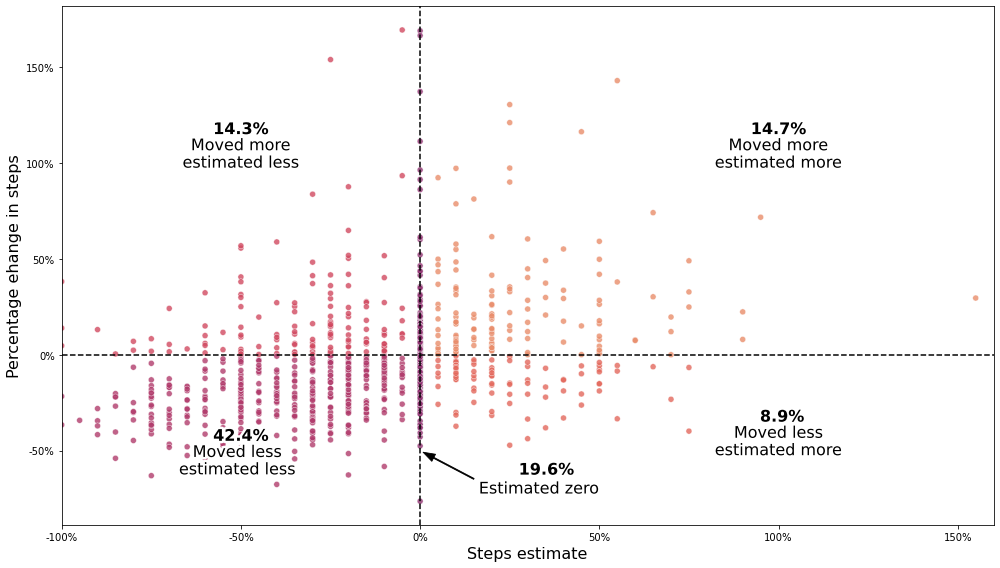

In [42]:
df = all_users_df.copy()

# Define the conditions for each quadrant
conditions = [
    (df['stepsEstimate'] > 0) & (df['change'] > 0),
    (df['stepsEstimate'] > 0) & (df['change'] < 0),
    (df['stepsEstimate'] < 0) & (df['change'] > 0),
    (df['stepsEstimate'] < 0) & (df['change'] < 0),
    (df['stepsEstimate'] == 0),
]

# Define the quadrant labels
quadrant_labels = [
    'Moved more estimated more',
    'Moved less estimated more',
    'Moved more estimated less',
    'Moved less estimated less',
    'Estimated zero',
]

# Assign a quadrant label to each data point
df['quadrant'] = np.select(conditions, quadrant_labels, default='Estimated zero')

# Calculate the percentage for each quadrant
quadrant_percentages = df['quadrant'].value_counts(normalize=True) * 100

# Define color palette
colors = sns.color_palette("flare")

# Define the color map for the quadrants
quadrant_colors = {
    'Moved more estimated more': colors[0],
    'Moved less estimated more': colors[1],
    'Moved more estimated less': colors[2],
    'Moved less estimated less': colors[3],
    'Estimated zero': colors[4],
}

# Plot the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df, 
    x='stepsEstimate', 
    y='change', 
    hue='quadrant', 
    palette=quadrant_colors, 
    alpha=0.8
)

# Add dashed lines for the quadrants
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Format the Y-axis as percentages (multiply by 100)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Add labels and title
plt.xlabel('Steps estimate', fontweight='normal', size=16)
plt.ylabel('Percentage ehange in steps', fontweight='normal', size=16)
# plt.title('Scatter Plot of Steps Estimate vs. Actual Percentage Change by Quadrant', fontweight='bold')

# Function to apply white outline to text
def apply_text_outline(text_obj):
    text_obj.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground='white'),
        path_effects.Normal()
    ])

# Extract the percentages for the four main quadrants and the zero estimations
more_more_pct = quadrant_percentages.get('Moved more estimated more', 0)
less_more_pct = quadrant_percentages.get('Moved less estimated more', 0)
more_less_pct = quadrant_percentages.get('Moved more estimated less', 0)
less_less_pct = quadrant_percentages.get('Moved less estimated less', 0)
estimated_zero = quadrant_percentages.get('Estimated zero', 0)

# Add quadrant labels inside the plot, including percentages
texts = []
fontsize = 16

number_offset = 0.175

texts.append(plt.text(1, 1, f'Moved more\nestimated more\n', 
         fontsize=fontsize, fontweight='normal', horizontalalignment='center', verticalalignment='center'))
texts.append(plt.text(1, 1 + number_offset, f'{more_more_pct:.1f}%', 
         fontsize=fontsize, fontweight='bold', horizontalalignment='center', verticalalignment='center'))

texts.append(plt.text(1, -0.5, f'Moved less\nestimated more\n', 
         fontsize=fontsize, fontweight='normal', horizontalalignment='center', verticalalignment='center'))
texts.append(plt.text(1.01, -0.5 + number_offset, f'{less_more_pct:.1f}%', 
         fontsize=fontsize, fontweight='bold', horizontalalignment='center', verticalalignment='center'))

texts.append(plt.text(-0.5, 1, f'Moved more\nestimated less\n', 
         fontsize=fontsize, fontweight='normal', horizontalalignment='center', verticalalignment='center'))
texts.append(plt.text(-0.5, 1 + number_offset, f'{more_less_pct:.1f}%', 
         fontsize=fontsize, fontweight='bold', horizontalalignment='center', verticalalignment='center'))

texts.append(plt.text(-0.51, -0.6, f'Moved less\nestimated less\n', 
         fontsize=fontsize, fontweight='normal', horizontalalignment='center', verticalalignment='center'))
texts.append(plt.text(-0.5, -0.6 + number_offset, f'{less_less_pct:.1f}%', 
         fontsize=fontsize, fontweight='bold', horizontalalignment='center', verticalalignment='center'))


texts.append(plt.annotate(f'{estimated_zero:.1f}%',
             xy=(0, -0.5), xytext=(0.275, -0.625), fontsize=fontsize, fontweight='bold'))
texts.append(plt.annotate(f'Estimated zero',
             xy=(0, -0.5), xytext=(0.5, -0.7), fontsize=fontsize, fontweight='normal',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, lw=0.8),
             horizontalalignment='right', verticalalignment='center'))

# Apply the white outline effect to all text objects
for text_obj in texts:
    apply_text_outline(text_obj)

# Remove the legend since we're placing the labels manually
plt.legend().remove()
plt.xlim(-1, 1.6)

# Show the plot
plt.tight_layout()
plt.show()

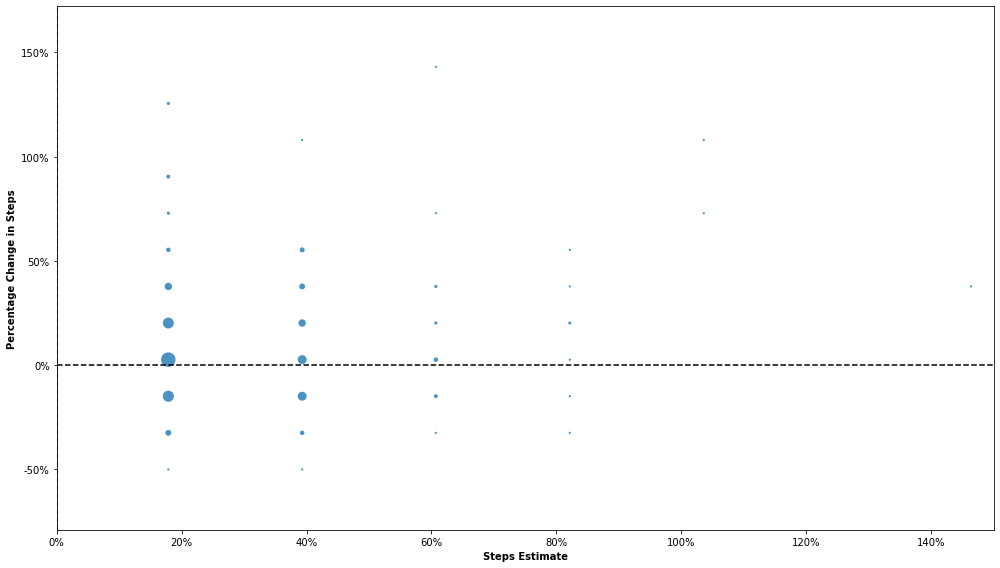

In [34]:

# Define bin sizes for grouping the data
bins_x = np.linspace(df['stepsEstimate'].min(), df['stepsEstimate'].max(), 15)  # 50 bins for x-axis
bins_y = np.linspace(df['change'].min(), df['change'].max(), 15)  # 50 bins for y-axis

# Create a new column for binned values
df['stepsEstimate_binned'] = pd.cut(df['stepsEstimate'], bins=bins_x)
df['change_binned'] = pd.cut(df['change'], bins=bins_y)

# Group by the binned values and count the occurrences in each bin
binned_df = df.groupby(['stepsEstimate_binned', 'change_binned']).size().reset_index(name='counts')

# Calculate the mid-point of each bin for plotting
binned_df['stepsEstimate_mid'] = binned_df['stepsEstimate_binned'].apply(lambda x: x.mid)
binned_df['change_mid'] = binned_df['change_binned'].apply(lambda x: x.mid)

# Plot the scatter plot with size corresponding to counts
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=binned_df, 
    x='stepsEstimate_mid', 
    y='change_mid', 
    size='counts', 
    sizes=(0, 500),  # Adjust marker size range
    palette='flare', 
    legend=False, 
    alpha=0.8
)

# Add dashed lines for the quadrants
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Invert the y-axis to match your other visualizations
plt.gca().invert_yaxis()

# Format the Y-axis as percentages
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Add labels and title
plt.xlabel('Steps Estimate', fontweight='bold')
plt.ylabel('Percentage Change in Steps', fontweight='bold')
# plt.title('Aggregated Scatter Plot of Steps Estimate vs. Actual Percentage Change', fontweight='bold')

# cut off the outlier in estimate ( > 150% )
plt.xlim(0, 1.5)

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
df = all_users_df.copy()

# Group by gender and ageRange and calculate the median of change, estimate, and difference
grouped_df = df.groupby(['gender', 'ageRange']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
}).reset_index()

# Format the percentage columns as human-readable percentages
grouped_df['change'] = (grouped_df['change'] * 100).round(1).astype(str) + '%'
grouped_df['stepsEstimate'] = (grouped_df['stepsEstimate'] * 100).round(1).astype(str) + '%'

# Group by gender only and calculate the same statistics
gender_df = df.groupby(['gender']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
}).reset_index()
gender_df['ageRange'] = 'All'

# Format the percentage columns as human-readable percentages
gender_df['change'] = (gender_df['change'] * 100).round(1).astype(str) + '%'
gender_df['stepsEstimate'] = (gender_df['stepsEstimate'] * 100).round(1).astype(str) + '%'

# Calculate the overall statistics across all genders and age ranges
overall_df = pd.DataFrame({
    'gender': ['All'],
    'ageRange': ['All'],
    'change': [(df['change'].median() * 100).round(1).astype(str) + '%'],
    'stepsEstimate': [(df['stepsEstimate'].median() * 100).round(1).astype(str) + '%'],
})

# Combine all dataframes
grouped_df = pd.concat([overall_df, gender_df, grouped_df], ignore_index=True)

# remove userId
grouped_df = grouped_df.drop(columns=['userId'])

# Format the table using tabulate
table = tabulate(grouped_df, headers='keys', tablefmt='psql', showindex=False)

# Print the table
print(table)

+----------+------------+----------+-----------------+
| gender   | ageRange   | change   | stepsEstimate   |
|----------+------------+----------+-----------------|
| All      | All        | -6.4%    | -10.0%          |
| female   | All        | -7.5%    | -15.0%          |
| male     | All        | -5.1%    | -10.0%          |
| female   | 18-24      | -13.3%   | -25.0%          |
| female   | 25-34      | -17.6%   | -25.0%          |
| female   | 35-44      | -3.6%    | -7.5%           |
| female   | 45-54      | -6.7%    | -20.0%          |
| female   | 55-64      | -5.4%    | -15.0%          |
| female   | 65+        | -2.9%    | 0.0%            |
| male     | 18-24      | -10.1%   | -27.5%          |
| male     | 25-34      | -7.1%    | -10.0%          |
| male     | 35-44      | -3.0%    | -15.0%          |
| male     | 45-54      | -5.2%    | -10.0%          |
| male     | 55-64      | 0.1%     | 0.0%            |
| male     | 65+        | -4.4%    | 0.0%            |
+---------

In [36]:
# Copy the original dataframe
df = all_users_df.copy()

# Calculate total users per age group and gender
age_gender_counts = df.groupby(['ageRange', 'gender']).agg({
    'userId': 'count'
}).reset_index()

# Pivot the table to get counts for Female and Male
pivot_df = age_gender_counts.pivot(index='ageRange', columns='gender', values='userId').fillna(0)
pivot_df = pivot_df.rename(columns=lambda x: x.title())  # Renaming gender columns to title case (Female, Male)

# Calculate percentages
# pivot_df['Female %'] = (pivot_df['Female'] / (pivot_df['Female'] + pivot_df['Male']) * 100).round(2).fillna(0).astype(str) + '%'
# pivot_df['Male %'] = (pivot_df['Male'] / (pivot_df['Female'] + pivot_df['Male']) * 100).round(2).fillna(0).astype(str) + '%'

# Reset the index to have ageRange as a column
pivot_df.reset_index(inplace=True)

# Format the table using tabulate
table = tabulate(pivot_df, headers='keys', tablefmt='psql', showindex=False)

# Print the table
print(table)

+------------+----------+--------+
| ageRange   |   Female |   Male |
|------------+----------+--------|
| 18-24      |       51 |     38 |
| 25-34      |       49 |     98 |
| 35-44      |      118 |     95 |
| 45-54      |      157 |    110 |
| 55-64      |       99 |     63 |
| 65+        |       54 |     41 |
+------------+----------+--------+


AttributeError: 'DataFrame' object has no attribute 'ageRange'

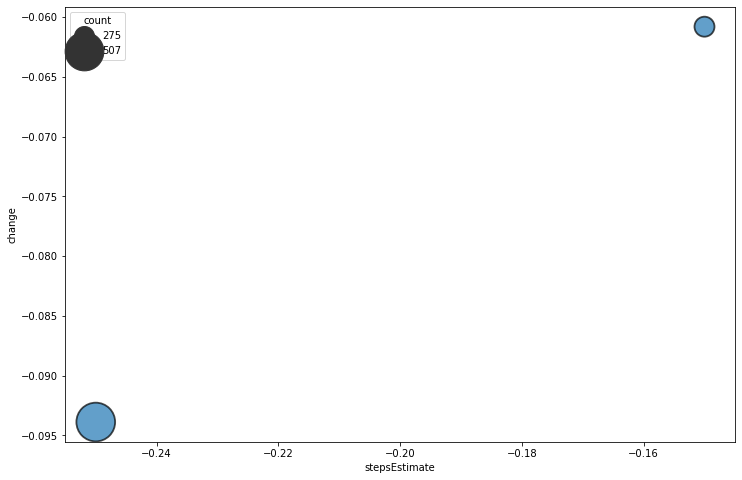

In [37]:
df = all_users_df.copy()

# Calculate the difference between change and estimate
df['difference'] = df['change'] - df['stepsEstimate']

# remove users with stepsEstimate == 0
df = df[df['stepsEstimate'] != 0]

# Group by gender and ageRange and calculate the median of change, estimate, and difference
df = df.groupby(['above_average']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'difference': 'median',
    'userId': 'count'
}).reset_index()
df.rename(columns={'userId': 'count'}, inplace=True)

plt.figure(figsize=(12, 8))

# Create scatter plot with uniform marker style (circles)
scatter = sns.scatterplot(
    data=df,
    x='stepsEstimate',
    y='change',
    # hue='gender',
    size='count',
    # style='above_average',
    sizes=(400, 1500),  # Adjust the range of bubble sizes
    palette='Set1',
    # size_norm=(df['count'].min(), df['count'].max()),  # Normalize bubble sizes
    alpha=0.7,
    edgecolor='black',
)

# Annotate each point with the corresponding ageRange
for line in range(0, df.shape[0]):
    plt.text(
        df.stepsEstimate[line], 
        df.change[line],
        df.ageRange[line],
        horizontalalignment='center',
        size='small',
        color='black',
        weight='semibold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Percentage Change', fontweight='bold')
plt.title('Scatter Plot of Steps Estimate vs. Change Grouped by Gender and Age Range', fontweight='bold')

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


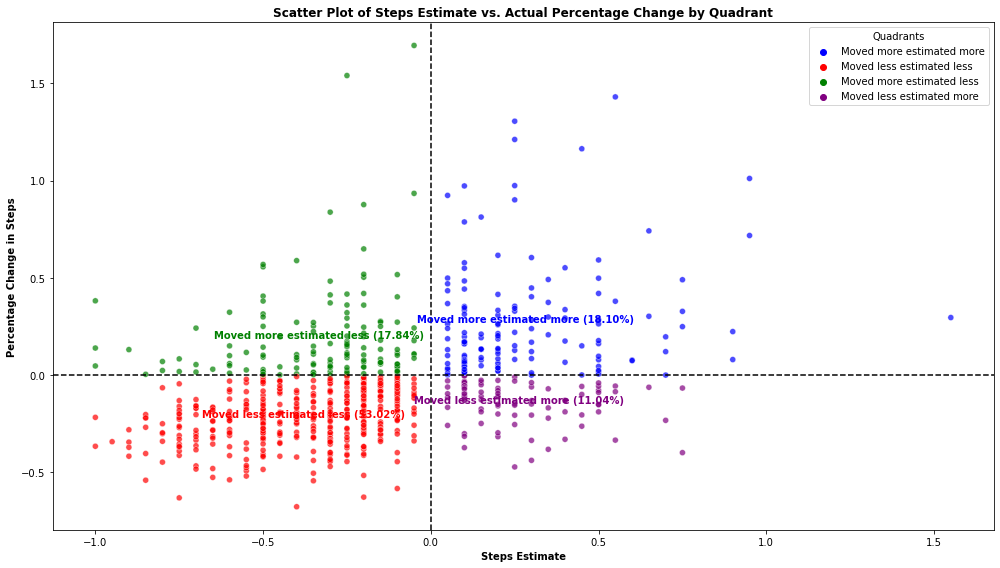

In [61]:
# Assuming your dataframe is named all_users_df and has the columns 'stepsEstimate' and 'change'
df = all_users_df.copy()  # replace this with your actual dataframe

# only take users with stepsEstimate != 0
df = df[df['stepsEstimate'] != 0]

# Define the conditions for each quadrant
conditions = [
    (df['stepsEstimate'] > 0) & (df['change'] > 0),
    (df['stepsEstimate'] > 0) & (df['change'] <= 0),
    (df['stepsEstimate'] <= 0) & (df['change'] > 0),
    (df['stepsEstimate'] <= 0) & (df['change'] <= 0)
]

# Define the quadrant labels
quadrant_labels = ['Moved more estimated more', 'Moved less estimated more', 'Moved more estimated less', 'Moved less estimated less']

# Assign a quadrant label to each data point
df['quadrant'] = np.select(conditions, quadrant_labels, default='Estimated zero')

# Define the color map for the quadrants
quadrant_colors = {
    'Moved more estimated more': 'blue',
    'Moved less estimated more': 'purple',
    'Moved more estimated less': 'green',
    'Moved less estimated less': 'red',
    'Estimated zero': 'grey'
}

# Plot the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df, 
    x='stepsEstimate', 
    y='change', 
    hue='quadrant', 
    palette=quadrant_colors, 
    alpha=0.7
)

# Add dashed lines for the quadrants
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Steps Estimate', fontweight='bold')
plt.ylabel('Percentage Change in Steps', fontweight='bold')
plt.title('Scatter Plot of Steps Estimate vs. Actual Percentage Change by Quadrant', fontweight='bold')

# Annotate each quadrant with the percentage of points it contains
for label, color in quadrant_colors.items():
    count = df[df['quadrant'] == label].shape[0]
    percentage = count / df.shape[0] * 100
    plt.text(
        x=np.mean(df[df['quadrant'] == label]['stepsEstimate']),
        y=np.mean(df[df['quadrant'] == label]['change']),
        s=f"{label} ({percentage:.2f}%)",
        color=color,
        weight='bold',
        ha='center'
    )

# Show the plot
plt.legend(title='Quadrants')
plt.tight_layout()
plt.show()

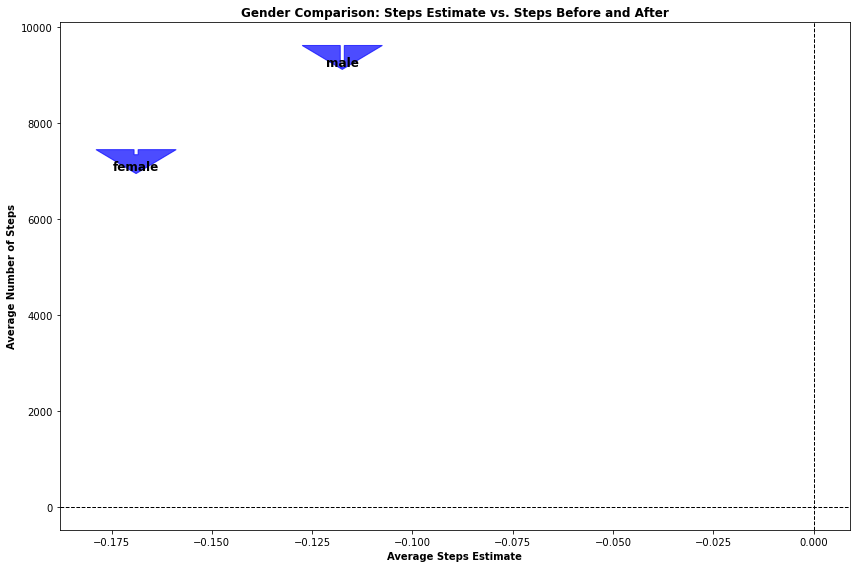

In [58]:
# Calculate the average values for each gender
gender_averages = all_users_df.groupby('gender').agg({
    'stepsBefore': 'mean',
    'stepsAfter': 'mean',
    'stepsEstimate': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))

# Plot arrows for each gender
for idx, row in gender_averages.iterrows():
    plt.arrow(
        x=row['stepsEstimate'], 
        y=row['stepsBefore'], 
        dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
        dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
        head_width=0.02,  # Adjust this value for the width of the arrowhead
        head_length=500,  # Adjust this value for the length of the arrowhead
        fc='blue',  # Face color of the arrow
        ec='blue',  # Edge color of the arrow
        alpha=0.7,
        length_includes_head=True
    )
    
    # Annotate the gender label at the end of the arrow
    plt.text(
        x=row['stepsEstimate'], 
        y=row['stepsAfter'], 
        s=row['gender'],
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Number of Steps', fontweight='bold')
plt.title('Gender Comparison: Steps Estimate vs. Steps Before and After', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

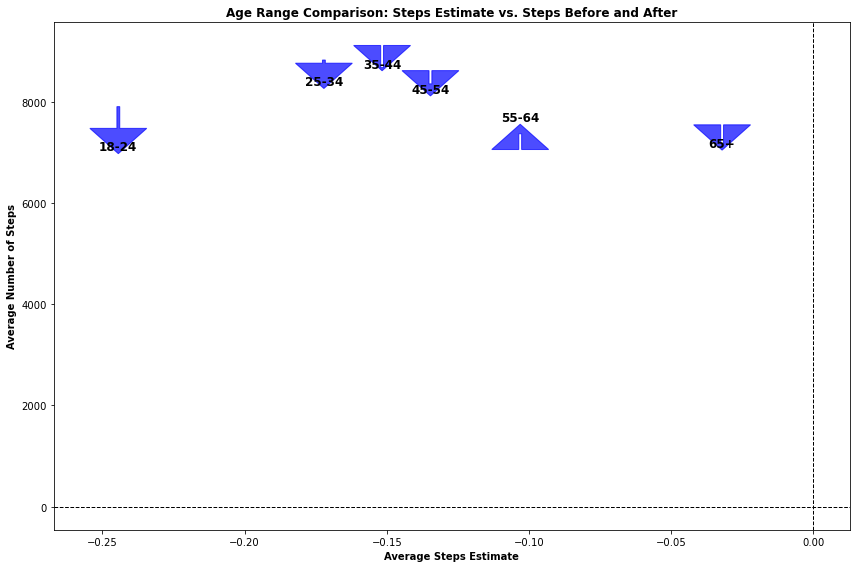

In [30]:

# Calculate the average values for each ageRange
age_range_averages = all_users_df.groupby('ageRange').agg({
    'stepsBefore': 'mean',
    'stepsAfter': 'mean',
    'stepsEstimate': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))

# Plot arrows for each age range
for idx, row in age_range_averages.iterrows():
    plt.arrow(
        x=row['stepsEstimate'], 
        y=row['stepsBefore'], 
        dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
        dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
        head_width=0.02,  # Adjust this value for the width of the arrowhead
        head_length=500,  # Adjust this value for the length of the arrowhead
        fc='blue',  # Face color of the arrow
        ec='blue',  # Edge color of the arrow
        alpha=0.7,
        length_includes_head=True
    )
    
    # Annotate the age range label at the end of the arrow
    plt.text(
        x=row['stepsEstimate'], 
        y=row['stepsAfter'], 
        s=row['ageRange'],
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Number of Steps', fontweight='bold')
plt.title('Age Range Comparison: Steps Estimate vs. Steps Before and After', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [59]:
# Function to filter data and plot
def plot_filtered_data(steps_before_threshold):
    plt.figure(figsize=(14, 8))

    # Filter the data based on the steps_before_threshold
    filtered_df = all_users_df[all_users_df['stepsBefore'] > steps_before_threshold]
    
    # Loop over each user to plot an arrow with color based on direction
    for idx, row in filtered_df.iterrows():
        # Determine the color based on whether stepsAfter is greater or less than stepsBefore
        arrow_color = 'green' if row['stepsAfter'] > row['stepsBefore'] else 'red'
        
        plt.arrow(
            x=row['stepsEstimate'], 
            y=row['stepsBefore'], 
            dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
            dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
            head_width=0.02,  # Adjust this value for the width of the arrowhead
            head_length=500,  # Adjust this value for the length of the arrowhead
            fc=arrow_color,  # Face color of the arrow
            ec=arrow_color,  # Edge color of the arrow
            alpha=0.3,  # Set opacity to make overlapping arrows more visible
            length_includes_head=True
        )

    # Add dashed lines for zero reference
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')

    # Add labels and title
    plt.xlabel('Steps Estimate', fontweight='bold')
    plt.ylabel('Number of Steps', fontweight='bold')
    plt.title(f'Steps Estimate vs. Steps with StepsBefore > {steps_before_threshold}', fontweight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Create an interactive slider for stepsBefore threshold
steps_before_slider = widgets.FloatSlider(
    value=0,  # Default value
    min=all_users_df['stepsBefore'].min(),  # Minimum value
    max=all_users_df['stepsBefore'].max(),  # Maximum value
    step=100,  # Step size for the slider
    description='StepsBefore >',
    continuous_update=False  # Update the plot only on release of the slider
)

# Use the interact function to link the slider to the plot function
widgets.interact(plot_filtered_data, steps_before_threshold=steps_before_slider)

# Display the slider
display(steps_before_slider)

interactive(children=(FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >…

FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >', max=28586.677595628…

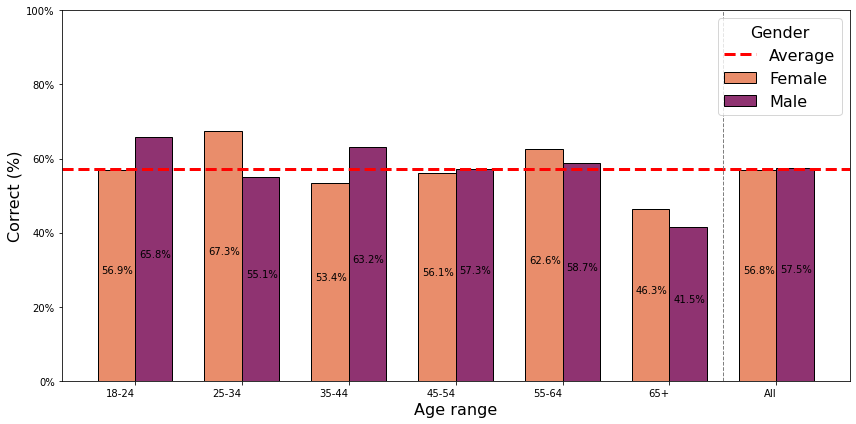

In [50]:
# Copy the original dataframe
df = all_users_df.copy()

# Group by gender and ageRange and calculate the median of change, stepsEstimate, and mean of correct
grouped_df = df.groupby(['gender', 'ageRange']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
    'correct': 'mean'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Calculate the overall statistics across all age ranges for each gender
overall_by_gender = df.groupby('gender').agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'correct': 'mean',
    'userId': 'count'
}).reset_index()
overall_by_gender['ageRange'] = 'All'
overall_by_gender.rename(columns={'userId': 'count'}, inplace=True)

# Combine the overall statistics with the grouped data
grouped_df = pd.concat([grouped_df, overall_by_gender], ignore_index=True)

# Filter out the "All" row for gender and include only relevant rows
filtered_df = grouped_df[grouped_df['gender'] != 'All']

# Get the "All" row for the overall average correct percentage across all genders and age ranges
overall_correct = df['correct'].mean()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
age_ranges = filtered_df['ageRange'].unique()
genders = filtered_df['gender'].unique()
x = np.arange(len(age_ranges))  # label locations
width = 0.35  # width of the bars

# colorblind_palette = sns.color_palette("colorblind", len(genders))
colors = [
    sns.color_palette("flare")[0],
    sns.color_palette("flare")[4],
]

# Plot bars for each gender using the colorblind-friendly palette
for i, gender in enumerate(genders):
    gender_data = filtered_df[filtered_df['gender'] == gender]
    bars = plt.bar(x + i * width, gender_data['correct'], width, label=gender.capitalize(), 
            edgecolor='black', color=colors[i])
    
    # Add percentage values on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            (bar.get_x() + bar.get_width() / 2) + 0.01,  # X-coordinate to center the text
            height / 2,  # Adjust this to move the text slightly inside the bar
            f'{height:.1%}',  # Format as percentage
            ha='center', va='bottom', color='black', fontweight='normal', fontsize='10'
        )


# Add the "All" line
plt.axhline(y=overall_correct, color='red', linestyle='--', label='Average', linewidth=3)
plt.axvline(x=5.68, color='gray', linestyle='--', linewidth=1)

# Set Y-axis limits and format to display as percentages
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add labels, title, and custom x-axis labels with bold font for consistency
plt.xlabel('Age range', fontweight='normal', fontsize=16)
plt.ylabel('Correct (%)', fontweight='normal', fontsize=16)
# plt.title('Correct Percentage by Gender and Age range', fontweight='bold')

# Set x-ticks and rotate labels
plt.xticks(x + width / 2, age_ranges, ha='right')

# Update legend to capitalize and bold font in title
plt.legend(title='Gender', title_fontsize='16', fontsize='16', loc='upper right')

plt.tight_layout()

# Show the plot
plt.show()


In [49]:
df['correct'].mean()

0.5714285714285714

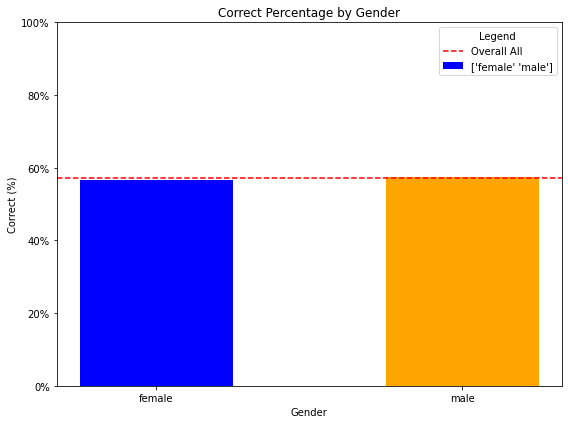

In [60]:
# Copy the original dataframe
df = all_users_df.copy()

# Group by gender only and calculate the median of change, stepsEstimate, and mean of correct
grouped_df = df.groupby(['gender']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
    'correct': 'mean'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Calculate the overall statistics across all genders
overall_correct = df['correct'].mean()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
genders = grouped_df['gender'].unique()
x = np.arange(len(genders))  # label locations
width = 0.5  # width of the bars

# Plot bars for each gender
plt.bar(x, grouped_df['correct'], width, color=['blue', 'orange'], label=genders)

# Add the "All" line
plt.axhline(y=overall_correct, color='red', linestyle='--', label='Overall All')

# Set Y-axis limits and format to display as percentages
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add labels, title, and custom x-axis labels
plt.xlabel('Gender')
plt.ylabel('Correct (%)')
plt.title('Correct Percentage by Gender')
plt.xticks(x, genders)
plt.legend(title='Legend')
plt.tight_layout()

# Show the plot
plt.show()

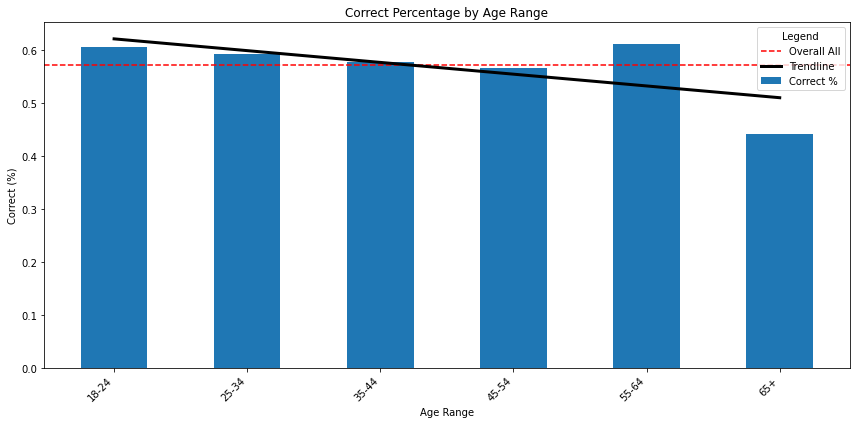

In [34]:
# Copy the original dataframe
df = all_users_df.copy()

# Group by ageRange and calculate the median of change, stepsEstimate, and mean of correct
grouped_df = df.groupby(['ageRange']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
    'correct': 'mean'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Calculate the overall statistics across all age ranges
overall_df = pd.DataFrame({
    'ageRange': ['All'],
    'change': [df['change'].median()],
    'stepsEstimate': [df['stepsEstimate'].median()],
    'count': [df.shape[0]],
    'correct': [df['correct'].mean()]
})

# Combine the overall statistics with the grouped data
grouped_df = pd.concat([overall_df, grouped_df], ignore_index=True)

# Filter out the "All" row for plotting
filtered_df = grouped_df[grouped_df['ageRange'] != 'All']

# Get the "All" row for the overall average correct percentage
overall_correct = overall_df['correct'].values[0]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
age_ranges = filtered_df['ageRange'].unique()
x = np.arange(len(age_ranges))  # label locations
width = 0.5  # width of the bars

# Plot bars for each age range
plt.bar(x, filtered_df['correct'], width, label='Correct %')

# Add the "All" line
plt.axhline(y=overall_correct, color='red', linestyle='--', label='Overall All')

# Calculate and plot the trendline
slope, intercept, r_value, p_value, std_err = linregress(x, filtered_df['correct'])
trendline = slope * x + intercept
plt.plot(x, trendline, color='black', linestyle='-', linewidth=3, label='Trendline')

# Add labels, title, and custom x-axis labels
plt.xlabel('Age Range')
plt.ylabel('Correct (%)')
plt.title('Correct Percentage by Age Range')
plt.xticks(x, age_ranges, rotation=45, ha='right')
plt.legend(title='Legend')
plt.tight_layout()

# Show the plot
plt.show()

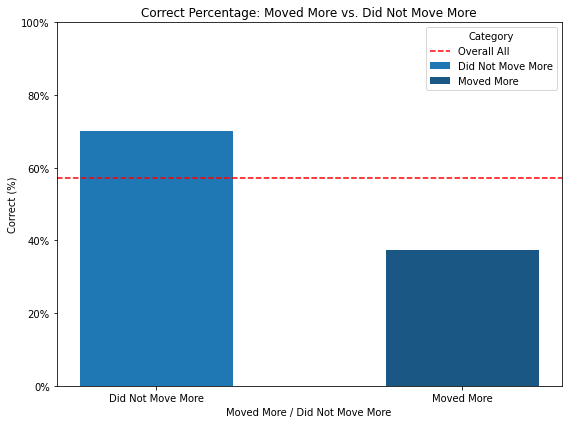

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copy the original dataframe
df = all_users_df.copy()

# Group by moved_more and calculate the mean of correct
grouped_df = df.groupby(['moved_more']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'userId': 'count',
    'correct': 'mean'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Get the overall average correct percentage
overall_correct = df['correct'].mean()

# Define colors: light color for did not move more, darker for moved more
colors = {
    'did_not_move_more': '#1f77b4',    # Light blue for did not move more
    'moved_more': '#1a5785'            # Darker blue for moved more
}

# Plotting the bar chart
plt.figure(figsize=(8, 6))
moved_more_categories = grouped_df['moved_more'].unique()
x = np.arange(len(moved_more_categories))  # label locations
width = 0.5  # width of the bars

# Plot bars for moved more and did not move more
for i, moved_more in enumerate(moved_more_categories):
    color = colors['moved_more'] if moved_more else colors['did_not_move_more']
    plt.bar(x[i], grouped_df[grouped_df['moved_more'] == moved_more]['correct'].values[0], width, color=color, label='Moved More' if moved_more else 'Did Not Move More')

# Add the "All" line
plt.axhline(y=overall_correct, color='red', linestyle='--', label='Overall All')

# Set Y-axis limits and format to display as percentages
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add labels, title, and custom x-axis labels
plt.xlabel('Moved More / Did Not Move More')
plt.ylabel('Correct (%)')
plt.title('Correct Percentage: Moved More vs. Did Not Move More')
plt.xticks(x, ['Did Not Move More', 'Moved More'])
plt.legend(title='Category')
plt.tight_layout()

# Show the plot
plt.show()



In [37]:
# Copy the original dataframe
df = all_users_df.copy()

# Calculate total users per age group and gender
age_gender_counts = df.groupby(['ageRange', 'gender']).agg({
    'userId': 'count'
}).reset_index()

# Pivot the table to get counts for Female and Male
pivot_df = age_gender_counts.pivot(index='ageRange', columns='gender', values='userId').fillna(0)
pivot_df = pivot_df.rename(columns=lambda x: x.title())  # Renaming gender columns to title case (Female, Male)

# Calculate percentages
pivot_df['Female %'] = (pivot_df['Female'] / (pivot_df['Female'] + pivot_df['Male']) * 100).round(2).fillna(0).astype(str) + '%'
pivot_df['Male %'] = (pivot_df['Male'] / (pivot_df['Female'] + pivot_df['Male']) * 100).round(2).fillna(0).astype(str) + '%'

# Reset the index to have ageRange as a column
pivot_df.reset_index(inplace=True)

# Format the table using tabulate
table = tabulate(pivot_df, headers='keys', tablefmt='psql', showindex=False)

# Print the table
print(table)

+------------+----------+--------+------------+----------+
| ageRange   |   Female |   Male | Female %   | Male %   |
|------------+----------+--------+------------+----------|
| 18-24      |       51 |     38 | 57.3%      | 42.7%    |
| 25-34      |       49 |     98 | 33.33%     | 66.67%   |
| 35-44      |      118 |     95 | 55.4%      | 44.6%    |
| 45-54      |      157 |    110 | 58.8%      | 41.2%    |
| 55-64      |       99 |     63 | 61.11%     | 38.89%   |
| 65+        |       54 |     41 | 56.84%     | 43.16%   |
+------------+----------+--------+------------+----------+


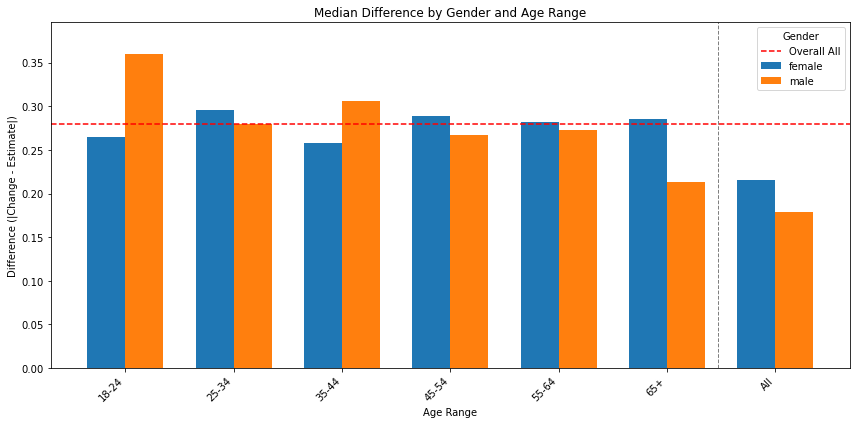

In [36]:
df = all_users_df.copy()


# Group by gender and ageRange and calculate the median of difference
grouped_df = df.groupby(['gender', 'ageRange']).agg({
    'difference': 'mean',
    'userId': 'count'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Calculate the overall statistics across all age ranges for each gender
overall_by_gender = df.groupby('gender').agg({
    'difference': 'median',
    'userId': 'count'
}).reset_index()
overall_by_gender['ageRange'] = 'All'
overall_by_gender.rename(columns={'userId': 'count'}, inplace=True)

# Combine the overall statistics with the grouped data
grouped_df = pd.concat([grouped_df, overall_by_gender], ignore_index=True)

# Filter out the "All" row for gender and include only relevant rows
filtered_df = grouped_df[grouped_df['gender'] != 'All']

# Get the "All" row for the overall average difference across all genders and age ranges
overall_difference = df['difference'].mean()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
age_ranges = filtered_df['ageRange'].unique()
genders = filtered_df['gender'].unique()
x = np.arange(len(age_ranges))  # label locations
width = 0.35  # width of the bars

# Plot bars for each gender
for i, gender in enumerate(genders):
    gender_data = filtered_df[filtered_df['gender'] == gender]
    plt.bar(x + i * width, gender_data['difference'], width, label=gender)

# Add the "All" line
plt.axhline(y=overall_difference, color='red', linestyle='--', label='Overall All')
plt.axvline(x=5.65, color='gray', linestyle='--', linewidth=1)

# Set Y-axis limits based on the range of difference values
plt.ylim(0, max(filtered_df['difference'].max(), overall_difference) * 1.1)

# Add labels, title, and custom x-axis labels
plt.xlabel('Age Range')
plt.ylabel('Difference (|Change - Estimate|)')
plt.title('Median Difference by Gender and Age Range')
plt.xticks(x + width / 2, age_ranges, rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()

# Show the plot
plt.show()

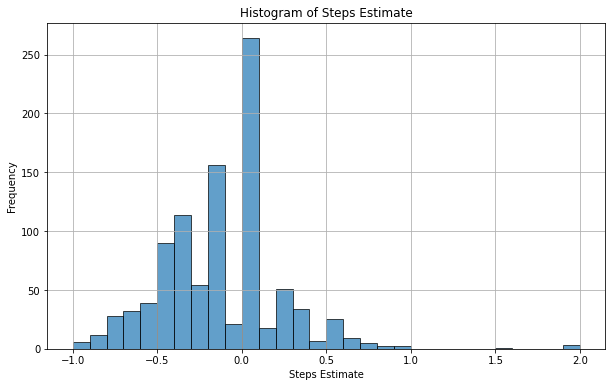

In [45]:
df = all_users_df.copy()

# Create a histogram for 'stepsEstimate'
plt.figure(figsize=(10, 6))
plt.hist(df['stepsEstimate'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Steps Estimate')
plt.xlabel('Steps Estimate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()